In [1]:

## Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
from dataLoader import getDataset
from torchsummary import summary

torch.manual_seed(43)  # for reproducibility


------------------ [WindowsPath('../data/simulations/L5PC_sim__Output_spikes_0748__Input_ranges_Exc_[0112,1126]_Inh_[0036,1288]_per100ms__simXsec_128x6_randseed_800130.p')]
Currently parsing file: L5PC_sim__Output_spikes_0748__Input_ranges_Exc_[0112,1126]_Inh_[0036,1288]_per100ms__simXsec_128x6_randseed_800130.p
(1, 1278, 30000)
Done, time elapsed: 3.943 

(1, 1278, 4500) (4500, 1)
(1, 1278, 25500) (25500, 1)
length 25500
25500
length 4500
4500


In [2]:
s
train_data, test_data = getDataset()
test_data = train_data


Currently parsing file: L5PC_sim__Output_spikes_0748__Input_ranges_Exc_[0112,1126]_Inh_[0036,1288]_per100ms__simXsec_128x6_randseed_800130.p
(1, 1278, 30000)
Done, time elapsed: 4.007 

(1, 1278, 4500) (4500, 1)
(1, 1278, 25500) (25500, 1)
length 25500
25500
length 4500
4500


In [4]:
count = 0
print(train_data.__len__())
print(test_data.__len__())
for batch in train_data:
    b = train_data[count]
    count+=1
    if count > 100000:
        break
print(count)

25500
4500
25501


In [5]:

## Helper Functions
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

BATCH_SIZE = 8
train_dl = DataLoader(train_data, BATCH_SIZE, num_workers=0)
test_dl = DataLoader(test_data, BATCH_SIZE, num_workers=4)


device = get_default_device()

train_loader = DeviceDataLoader(train_dl, device)
val_loader = DeviceDataLoader(test_dl, device)


In [6]:
mse_loss = nn.MSELoss()


def round(x, decimals=0):
    b = 10**decimals
    return torch.round(x*b)/b


predictionList = []

def accuracy(outputs, labels):
    preds, _ = torch.max(outputs, dim=1)
    labels = round(labels, decimals=0)
    preds =  round(preds, decimals=0)
    global predictionList

    predictionList += preds
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))




class BaseModule(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)
        loss = mse_loss(out, labels) 
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)  
        loss = mse_loss(out, labels)   
        acc = accuracy(out, labels)        
        return {'val_loss': loss.detach(), 'val_acc': acc}
    
    def train_val_step(self, batch):
        images, labels = batch
        out = self(images)      
        loss = mse_loss(out, labels)
        acc = accuracy(out, labels)        
        return {'train_loss': loss.detach(), 'train_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
       
    def epoch_end(self, epoch, result):
        print("Epoch {}, Validation Loss: {:.4f}, Validation Accuracy: {:.4f}".format(epoch + 1, result['val_loss'], result['val_acc']))
        

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []

    if opt_func == torch.optim.SGD:
        optimizer = opt_func(model.parameters(), lr, momentum=0.9)
    else:
        optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history


def plotResults(history,name):
    losses = [entry['val_loss'] for entry in history]
    accuracy = [entry["val_acc"] for entry in history]
    train_loss = [entry["train_loss"] for entry in history]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
    fig.suptitle('Model Results')

    ax1.plot(losses, '-o', label="Validation Loss")
    ax1.plot(train_loss, "-s", label="Training Loss")
    ax1.legend()
    ax1.set_ylim([0,5])
    ax1.set(xlabel = 'Epoch', ylabel="Loss")

    
    ax2.set(xlabel = 'Epoch', ylabel="Values")
    ax2.plot(accuracy, "-r")

    # plt.legend()
    ax1.set_title('Loss vs. Number of Epochs');
    ax2.set_title("Top 1% Accuracy on Validation Set");
    plt.savefig("{}-results.png".format(name))
    plt.show()

    
histories = []

In [19]:
class SimpleNet(BaseModule):
    def __init__(self):
        super(SimpleNet, self).__init__()

        self.net = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 32 x 639 x 250
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 32 x 320 x 125
    
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 32 x 160 x 63
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 80 x 32
    
            nn.Flatten(), 
            nn.Linear(45504, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
        )
    def forward(self, xb):
        xb = xb.float()
        res = self.net(xb)
        return res.to(dtype=torch.float64)

# input_shape = (3,1278,500)
# summary(SimpleNet(), input_shape)


In [8]:
CUDA_LAUNCH_BLOCKING=1
print(device)
model = to_device(SimpleNet(), device)
# mode = model.to(device)
history = [evaluate(model, val_loader)]
num_epochs = 10
opt_func = torch.optim.SGD
lr = 4e-2
history += fit(num_epochs, lr, model, train_loader, val_loader)
histories.append(history)
plotResults(history[1:], "SimpleNet")


cuda


C:\Users\Amean\anaconda3\envs\neuron\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Amean\anaconda3\envs\neuron\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1, Validation Loss: nan, Validation Accuracy: 0.0000
Epoch 2, Validation Loss: nan, Validation Accuracy: 0.0000


KeyboardInterrupt: 

In [40]:
class Net1(BaseModule):
    def __init__(self):
        super(Net1, self).__init__()

        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1278, 2000),
            nn.ReLU(),
            nn.Linear(2000, 1000),
            nn.ReLU(),
            nn.Linear(1000, 512),
            nn.ReLU(),
            nn.Linear(512, 1),
          
        )
    def forward(self, x):
        x = x.float()
        res = self.net(x)
#         print(res)
        return res.to(dtype=torch.float64)


In [5]:
class Net1(BaseModule):
    def __init__(self):
        super(Net1, self).__init__()

        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1278, 1),
          
        )
    def forward(self, x):
        x = x.float()
        res = self.net(x)
#         print(res)
        return res.to(dtype=torch.float64)

Epoch 1, Validation Loss: 14.2128, Validation Accuracy: 0.1298
Epoch 2, Validation Loss: 16.7212, Validation Accuracy: 0.1318
Epoch 3, Validation Loss: 16.4434, Validation Accuracy: 0.1336
Epoch 4, Validation Loss: 15.0815, Validation Accuracy: 0.1376
Epoch 5, Validation Loss: 15.2817, Validation Accuracy: 0.1366
Epoch 6, Validation Loss: 13.2505, Validation Accuracy: 0.1372
Epoch 7, Validation Loss: 13.8480, Validation Accuracy: 0.1516
Epoch 8, Validation Loss: 11.5767, Validation Accuracy: 0.1620
Epoch 9, Validation Loss: 11.7481, Validation Accuracy: 0.1648
Epoch 10, Validation Loss: 9.6894, Validation Accuracy: 0.1712


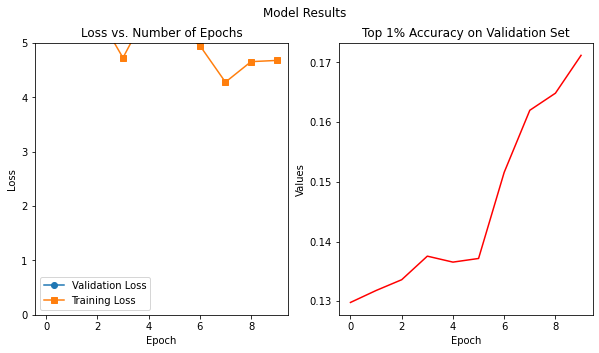

In [41]:
model = to_device(Net1(), device)
history = [evaluate(model, val_loader)]
num_epochs = 10
opt_func = torch.optim.Adam
lr = 1e-3
history += fit(num_epochs, lr, model, train_loader, val_loader, opt_func)
histories.append(history)
plotResults(history[1:], "Net1")

In [ ]:
# length = len(train_data)
# lengthPred = len(predictionList)
# vals = predictionList[lengthPred - length:]

# valsFloat = []

# for val in vals:
#     valsFloat.append(float(val))

lim = 1000
truth = []
count = 0
while count < lim:
    batch = train_data[count]
#     print(batch[100][1])
    value = float(batch[1])
    truth.append(value)
    count+=1
    
# item = train_data[3]
# b = item[1]
# print(float(b))
plt.figure()
plt.plot(truth, "-r")
# plt.plot(valsFloat)
plt.show()

In [42]:
item = train_data[2]
item1 = item[0].float()

limit = 200;
counter = 0
truthVal = []
pred = []
while counter < limit:
    dataInput, out  = train_data[counter]
   
    truthVal.append(float(out))
    dataInput = torch.transpose(dataInput, 0, 1)
    inputVal = dataInput.float()
    modelres = model(inputVal.to("cuda"))
    pred.append(float(modelres))
    counter+=1



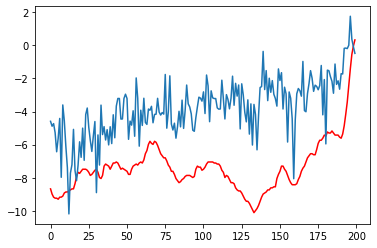

In [29]:

plt.figure()
plt.plot(truthVal, "-r")
plt.plot(pred)
plt.show()

In [7]:

class CausalConv1d(nn.Conv1d):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride=1,
                 dilation=1,
                 groups=1,
                 bias=True):
        self.__padding = (kernel_size - 1) * dilation

        super(CausalConv1d, self).__init__(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=self.__padding,
            dilation=dilation,
            groups=groups,
            bias=bias)

    def forward(self, input):
        result = super(CausalConv1d, self).forward(input)
        if self.__padding != 0:
            return result[:, :, :-self.__padding]
        return result
    

class Net1(BaseModule):
    def __init__(self):
        super(Net1, self).__init__()

        self.net = nn.Sequential(
            CausalConv1d(in_channels=1278, out_channels=32, kernel_size=3, stride=1, dilation=1, groups=1, bias=True),
            nn.BatchNorm1d(num_features=32, eps=0.001, momentum=0.99,
                                     affine=True, track_running_stats=True),
            nn.ReLU(),
            CausalConv1d(in_channels=32, out_channels=32, kernel_size=3, stride=1, dilation=1, groups=1, bias=True),
            nn.BatchNorm1d(num_features=32, eps=0.001, momentum=0.99,
                                     affine=True, track_running_stats=True),
            nn.ReLU(),
            CausalConv1d(in_channels=32, out_channels=32, kernel_size=3, stride=1, dilation=1, groups=1, bias=True),
            nn.BatchNorm1d(num_features=32, eps=0.001, momentum=0.99,
                                     affine=True, track_running_stats=True),
            nn.ReLU(),
              CausalConv1d(in_channels=32, out_channels=32, kernel_size=3, stride=1, dilation=1, groups=1, bias=True),
            nn.BatchNorm1d(num_features=32, eps=0.001, momentum=0.99,
                                     affine=True, track_running_stats=True),
            nn.ReLU(),
            CausalConv1d(in_channels=32, out_channels=1, kernel_size=3, stride=1, dilation=1, groups=1, bias=True),
            nn.BatchNorm1d(num_features=1, eps=0.001, momentum=0.99,
                                     affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.Flatten(), 
            nn.Linear(80, 1),
        )
    def forward(self, x):
        x = x.float()
        res = self.net(x)
        return res.to(dtype=torch.float64)




Epoch 1, Validation Loss: 22.3181, Validation Accuracy: 0.0599
Epoch 2, Validation Loss: 18.9293, Validation Accuracy: 0.0762
Epoch 3, Validation Loss: 16.9711, Validation Accuracy: 0.0938
Epoch 4, Validation Loss: 16.1075, Validation Accuracy: 0.1031
Epoch 5, Validation Loss: 15.7596, Validation Accuracy: 0.1111
Epoch 6, Validation Loss: 15.8932, Validation Accuracy: 0.1133
Epoch 7, Validation Loss: 16.2886, Validation Accuracy: 0.1138
Epoch 8, Validation Loss: 17.2730, Validation Accuracy: 0.1083
Epoch 9, Validation Loss: 18.1734, Validation Accuracy: 0.1051
Epoch 10, Validation Loss: 19.2742, Validation Accuracy: 0.1009


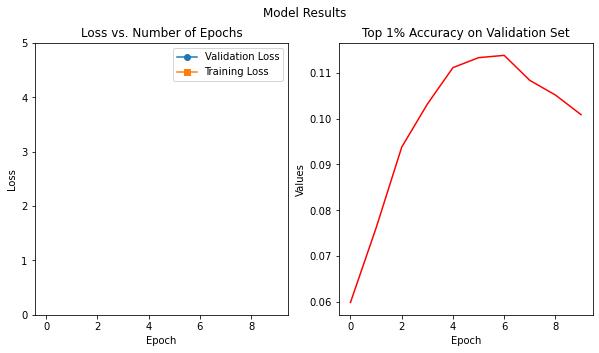

In [9]:

model = to_device(Net1(), device)
history = [evaluate(model, val_loader)]
num_epochs = 10
opt_func = torch.optim.Adam
lr = 4e-5
history += fit(num_epochs, lr, model, train_loader, val_loader, opt_func)
histories.append(history)
plotResults(history[1:], "Net1")


In [18]:
limit = 5000;
counter = 0
truthVal = []
pred = []
while counter < limit:
    dataInput, out  = train_data[counter]
    truthVal.append(float(out))
    inputVal = dataInput.float()
    modelres = model(inputVal.to("cuda"))
    pred.append(float(modelres))
    counter+=1

plt.figure()
plt.plot(truthVal, "-r")
plt.plot(pred)
plt.show()


RuntimeError: Expected 3-dimensional input for 3-dimensional weight [8, 1278, 3], but got 2-dimensional input of size [1278, 150] instead